# Examples of plots and calculations using the tmm package

## Imports

In [15]:
from __future__ import division, print_function, absolute_import

from tmm import (coh_tmm, unpolarized_RT, ellips,
                       position_resolved, find_in_structure_with_inf)
import numpy as np
import pandas as pd

import pyradi.ryplot as ryplot
# from numpy import pi, linspace, inf, array
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
%matplotlib inline

## Set up

In [16]:
try:
    import colorpy.illuminants
    import colorpy.colormodels
    from tmm import color
    colors_were_imported = True
except ImportError:
    # without colorpy, you can't run sample5(), but everything else is fine.
    colors_were_imported = False


# "5 * degree" is 5 degrees expressed in radians
# "1.2 / degree" is 1.2 radians expressed in degrees
degree = np.pi/180

## MWE single surface

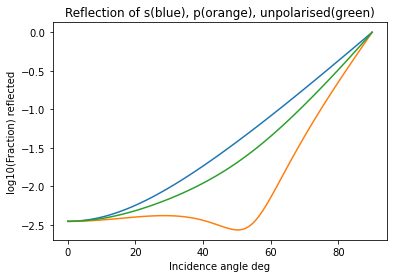

In [17]:
from tmm import (coh_tmm, unpolarized_RT, ellips,
                       position_resolved, find_in_structure_with_inf)
import numpy as np
import matplotlib.pyplot as plt

degree = np.pi/180
wl = 1.064 # in um
qwl = 0.25 # ideal case
ks = (1e2/1e9)*1e4/(wl)
gindex = 1.5066352
degrees = np.linspace(0,90,90)
thick = 1000.*(wl/gindex)/4
# list of layer thicknesses in nm
d_list = [np.inf,thick,np.inf]
# list of refractive indices
n_list = [1,np.sqrt(gindex),gindex] 

plt.figure();
R=[] 
Rs=[] 
Rp=[] 

for deg in degrees:
    Rs.append(coh_tmm('s',n_list, d_list, deg*degree, 1/ks)['R'])
    Rp.append(coh_tmm('p',n_list, d_list, deg*degree, 1/ks)['R'])
    R.append(unpolarized_RT(n_list, d_list, deg*degree, 1/ks)['R'])
plt.plot(degrees,np.log10(Rs),degrees,np.log10(Rp), degrees,np.log10(R));

plt.xlabel('Incidence angle deg')
plt.ylabel('log10(Fraction) reflected')
plt.title('Reflection of s(blue), p(orange), unpolarised(green)');

## Sample 0

Here's a thin non-absorbing layer, on top of a thick absorbing layer, with
air on both sides. Plotting reflected intensity versus incidence angle, at a single wavelength


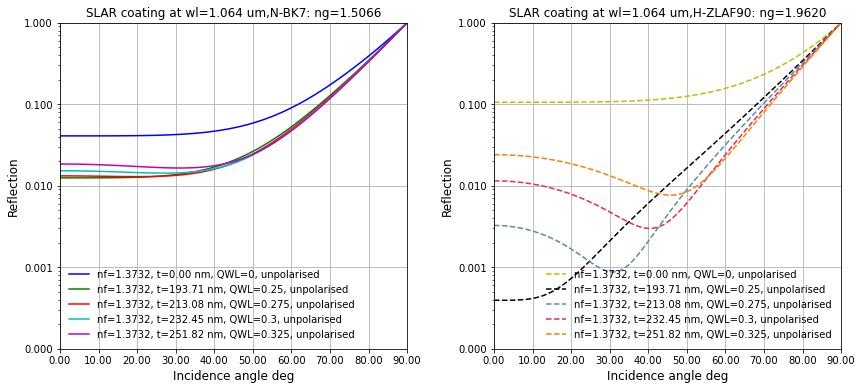

In [28]:
wl = 1.064 # in um
qwls = [0,0.25,0.275,0.3,0.325]
gindexs = {
    'N-BK7':[1.5066352,'-'],
    'H-ZLAF90':[1.9620032427705283 ,'--']
}
cindex = 1.3732 # MgF2

p = ryplot.Plotter(1,1,2,figsize=(14,6));
ks = (1e2/1e9)*1e4/(wl)

df = pd.DataFrame()

degrees = np.linspace(0,90,91)
for ii,key in enumerate(gindexs.keys()):
    for qwl in qwls:
        gindex = gindexs[key][0]
        linestyle = gindexs[key][1]
        thick = 1000.*wl*qwl/cindex
        
        # # list of layer thicknesses in nm
        # d_list = [np.inf,thick,5,thick,np.inf]
        # # list of refractive indices
        # n_list = [1,cindex,gindex,cindex,1]    
        
        # list of layer thicknesses in nm
        d_list = [np.inf,thick,np.inf]
        # list of refractive indices
        n_list = [1,cindex,gindex]     
        
        stgh = f'SLAR coating at wl={wl} um,{key}: ng={gindexs[key][0]:.4f}'
        stgc = f'nf={n_list[1]:.4f}, t={thick:.2f} nm, QWL={qwl}'
        # initialize lists of y-values to plot
        R=[] 
        Rs=[] 
        Rp=[] 

        for deg in degrees:
            Rs.append(coh_tmm('s',n_list, d_list, deg*degree, 1/ks)['R'])
            Rp.append(coh_tmm('p',n_list, d_list, deg*degree, 1/ks)['R'])
            R.append(unpolarized_RT(n_list, d_list, deg*degree, 1/ks)['R'])
            
            df = df.append({'wl':wl,'QWL':qwl,'Material':key,'n':gindex,'thick':thick,
                            'Angle':deg,'Ru':R[-1],'Rs':Rs[-1],'Rp':Rp[-1]
                           },ignore_index=True)
            
            
            
        if False:
            p.semilogY(ii+1,degrees,np.asarray(Rs),
                label=[f'{stgc}, s-polarised'],linestyle=linestyle)
            p.semilogY(ii+1,degrees,np.asarray(Rp),
                label=[f'{stgc}, p-polarised'],linestyle=linestyle);
        p.semilogY(ii+1,degrees,np.asarray(R),stgh,'Incidence angle deg','Reflection',linestyle=linestyle,
                   label=[f'{stgc}, unpolarised'],yAxisFmt='%.3f',pltaxis=[0,90,0.0001,1]);
# print(df)
df.to_csv('SLARR.xlsx') 

## Sample 1

Here's a thin non-absorbing layer, on top of a thick absorbing layer, with
air on both sides. Plotting reflected intensity versus wavenumber, at two
different incident angles.


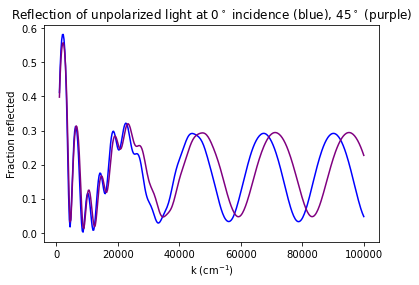

In [19]:
# list of layer thicknesses in nm
d_list = [np.inf,100,300,np.inf]
# list of refractive indices
n_list = [1,2.2,3.3+0.3j,1]
# list of wavenumbers to plot in nm^-1
ks=np.linspace(0.0001,.01,num=400)
# initialize lists of y-values to plot
Rnorm=[] 
R45=[]
for k in ks:
    # For normal incidence, s and p polarizations are identical.
    # I arbitrarily decided to use 's'.
    Rnorm.append(coh_tmm('s',n_list, d_list, 0, 1/k)['R'])
    R45.append(unpolarized_RT(n_list, d_list, 45*degree, 1/k)['R'])
kcm = ks * 1e7 #ks in cm^-1 rather than nm^-1
plt.figure()
plt.plot(kcm,Rnorm,'blue',kcm,R45,'purple')
plt.xlabel('k (cm$^{-1}$)')
plt.ylabel('Fraction reflected')
plt.title('Reflection of unpolarized light at 0$^\circ$ incidence (blue), '
            '45$^\circ$ (purple)');

## Sample 2

Here's the transmitted intensity versus wavelength through a single-layer
film which has some complicated wavelength-dependent index of refraction.
(I made these numbers up, but in real life they could be read out of a
graph / table published in the literature.) Air is on both sides of the
film, and the light is normally incident.

In [ ]:
#index of refraction of my material: wavelength in nm versus index.
material_nk_data = np.array([[200, 2.1+0.1j],
                          [300, 2.4+0.3j],
                          [400, 2.3+0.4j],
                          [500, 2.2+0.4j],
                          [750, 2.2+0.5j]])
material_nk_fn = interp1d(material_nk_data[:,0].real,
                          material_nk_data[:,1], kind='quadratic')
d_list = [np.inf,300,np.inf] #in nm
lambda_list = np.linspace(200,750,400) #in nm
T_list = []
for lambda_vac in lambda_list:
    n_list = [1, material_nk_fn(lambda_vac), 1]
    T_list.append(coh_tmm('s',n_list,d_list,0,lambda_vac)['T'])
plt.figure()
plt.plot(lambda_list,T_list)
plt.xlabel('Wavelength (nm)')
plt.ylabel('Fraction of power transmitted')
plt.title('Transmission at normal incidence');


## Sample 3

Here is a calculation of the psi and Delta parameters measured in
ellipsometry. This reproduces Fig. 1.14 in Handbook of Ellipsometry by
Tompkins, 2005.

In [ ]:
n_list=[1,1.46,3.87+0.02j]
ds=np.linspace(0,1000,num=100) #in nm
psis=[]
Deltas=[]
for d in ds:
    e_data=ellips(n_list, [np.inf,d,np.inf], 70*degree, 633) #in nm
    psis.append(e_data['psi']/degree) # angle in degrees
    Deltas.append(e_data['Delta']/degree) # angle in degrees
plt.figure()
plt.plot(ds,psis,ds,Deltas)
plt.xlabel('SiO2 thickness (nm)')
plt.ylabel('Ellipsometric angles (degrees)')
plt.title('Ellipsometric parameters for air/SiO2/Si, varying '
        'SiO2 thickness.\n' 
        '@ 70$^\circ$, 633nm. '
        'Should agree with Handbook of Ellipsometry Fig. 1.14');

# Sample 4

Here is an example where we plot absorption and Poynting vector
as a function of depth.

In [ ]:
d_list = [np.inf, 100, 300, np.inf] #in nm
n_list = [1, 2.2+0.2j, 3.3+0.3j, 1]
th_0=np.pi/4
lam_vac=400
pol='p'
coh_tmm_data = coh_tmm(pol,n_list,d_list,th_0,lam_vac)

ds = np.linspace(0,400,num=1000) #position in structure
poyn=[]
absor=[]
for d in ds:
    layer, d_in_layer = find_in_structure_with_inf(d_list,d)
    data=position_resolved(layer,d_in_layer,coh_tmm_data)
    poyn.append(data['poyn'])
    absor.append(data['absor'])
# convert data to numpy arrays for easy scaling in the plot
poyn = np.array(poyn)
absor =np.array(absor)
plt.figure()
plt.plot(ds,poyn,'blue',ds,200*absor,'purple')
plt.xlabel('depth (nm)')
plt.ylabel('AU')
plt.title('Local absorption (purple), Poynting vector (blue)');

# Sample 5

Color calculations: What color is a air / thin SiO2 / Si wafer?

In [ ]:
if not colors_were_imported:
    print('Colorpy was not detected (or perhaps an error occurred when',
          'loading it). You cannot do color calculations, sorry!',
          'http://pypi.python.org/pypi/colorpy')
else:

    # Crystalline silicon refractive index. Data from Palik via
    # http://refractiveindex.info, I haven't checked it, but this is just for
    # demonstration purposes anyway.
    Si_n_data = [[400, 5.57 + 0.387j],
                 [450, 4.67 + 0.145j],
                 [500, 4.30 + 7.28e-2j],
                 [550, 4.08 + 4.06e-2j],
                 [600, 3.95 + 2.57e-2j],
                 [650, 3.85 + 1.64e-2j],
                 [700, 3.78 + 1.26e-2j]]
    Si_n_data = np.array(Si_n_data)
    Si_n_fn = interp1d(Si_n_data[:,0], Si_n_data[:,1], kind='linear')
    # SiO2 refractive index (approximate): 1.46 regardless of wavelength
    SiO2_n_fn = lambda wavelength : 1.46
    # air refractive index
    air_n_fn = lambda wavelength : 1

    n_fn_list = [air_n_fn, SiO2_n_fn, Si_n_fn]
    th_0 = 0

    # Print the colors, and show plots, for the special case of 300nm-thick SiO2
    d_list = [np.inf, 300, np.inf]
    reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
    illuminant = colorpy.illuminants.get_illuminant_D65()
    spectrum = color.calc_spectrum(reflectances, illuminant)
    color_dict = color.calc_color(spectrum)
    print('air / 300nm SiO2 / Si --- rgb =', color_dict['rgb'], ', xyY =', color_dict['xyY'])
    plt.figure()
    color.plot_reflectances(reflectances,
                        title='air / 300nm SiO2 / Si -- '
                              'Fraction reflected at each wavelength')
    plt.figure()
    color.plot_spectrum(spectrum,
                        title='air / 300nm SiO2 / Si -- '
                              'Reflected spectrum under D65 illumination')

    # Calculate irgb color (i.e. gamma-corrected sRGB display color rounded to
    # integers 0-255) versus thickness of SiO2
    max_SiO2_thickness = 600
    SiO2_thickness_list = np.linspace(0,max_SiO2_thickness,num=80)
    irgb_list = []
    for SiO2_d in SiO2_thickness_list:
        d_list = [np.inf, SiO2_d, np.inf]
        reflectances = color.calc_reflectances(n_fn_list, d_list, th_0)
        illuminant = colorpy.illuminants.get_illuminant_D65()
        spectrum = color.calc_spectrum(reflectances, illuminant)
        color_dict = color.calc_color(spectrum)
        irgb_list.append(color_dict['irgb'])

    # Plot those colors
    print('Making color vs SiO2 thickness graph. Compare to (for example)')
    print('http://www.htelabs.com/appnotes/sio2_color_chart_thermal_silicon_dioxide.htm')
    plt.figure()
    plt.plot([0,max_SiO2_thickness],[1,1])
    plt.xlim(0,max_SiO2_thickness)
    plt.ylim(0,1)
    plt.xlabel('SiO2 thickness (nm)')
    plt.yticks([])
    plt.title('Air / SiO2 / Si color vs SiO2 thickness')
    for i in range(len(SiO2_thickness_list)):
        # One strip of each color, centered at x=SiO2_thickness_list[i]
        if i==0:
            x0 = 0
        else:
            x0 = (SiO2_thickness_list[i] + SiO2_thickness_list[i-1]) / 2
        if i == len(SiO2_thickness_list) - 1:
            x1 = max_SiO2_thickness
        else:
            x1 = (SiO2_thickness_list[i] + SiO2_thickness_list[i+1]) / 2
        y0 = 0
        y1 = 1
        poly_x = [x0,  x1,  x1, x0]
        poly_y = [y0, y0, y1, y1]
        color_string = colorpy.colormodels.irgb_string_from_irgb(irgb_list[i])
        plt.fill(poly_x, poly_y, color_string, edgecolor=color_string)


# Sample 6

An example reflection plot with a surface plasmon resonance (SPR) dip. Compare with http://doi.org/10.2320/matertrans.M2010003 ("Spectral and Angular Responses of Surface Plasmon Resonance Based on the Kretschmann Prism Configuration") Fig 6a

In [ ]:
# list of layer thicknesses in nm
d_list = [np.inf, 5, 30, np.inf]
# list of refractive indices
n_list = [1.517, 3.719+4.362j, 0.130+3.162j, 1]
# wavelength in nm
lam_vac = 633
# list of angles to plot
theta_list = np.linspace(30*degree, 60*degree, num=300)
# initialize lists of y-values to plot
Rp = []
for theta in theta_list:
    Rp.append(coh_tmm('p', n_list, d_list, theta, lam_vac)['R'])
plt.figure()
plt.plot(theta_list/degree, Rp, 'blue')
plt.xlabel('theta (degree)')
plt.ylabel('Fraction reflected')
plt.xlim(30, 60)
plt.ylim(0, 1)
plt.title('Reflection of p-polarized light with Surface Plasmon Resonance\n'
          'Compare with http://doi.org/10.2320/matertrans.M2010003 Fig 6a');